# Machine Learning for Complete Intersection Calabi-Yau Manifolds

We use a machine learning (ML) approach to the prediction of the **Hodge numbers** $h_{11}$ and $h_{21}$ of **Calabi-Yau** (CY) 3-folds in the framework of **String Theory**. First of all we analyse the dataset of the manifolds and build a consistent preanalysis to visualise the distribution of the data and extract the usable features. We then move to the machine learning analysis by including the results of the **regression** task performed using different algorithms.

## Infrastructure

We print information about the current OS:

In [1]:
from mltools.libos import InfoOS

print('Current OS:                  {} (kernel release: {}, architecture: {})'.format(InfoOS().os, InfoOS().kernel, InfoOS().arch))
print('Number of available threads: {:d}'.format(InfoOS().threads))
print('Current CPU frequency:       {:.0f} MHz (max: {:.0f} MHz)'.format(InfoOS().freq, InfoOS().freqm))
print('Available RAM memory:        {:d} MB (tot: {:d} MB)'.format(InfoOS().vmav, InfoOS().vmtot))

Current OS:                  Linux (kernel release: 5.6.6-arch1-1, architecture: x86_64)
Number of available threads: 8
Current CPU frequency:       3470 MHz (max: 3800 MHz)
Available RAM memory:        9001 MB (tot: 15758 MB)


We then print information on the current GPU setup (if available):

In [2]:
!nvidia-smi

Thu Apr 23 16:08:31 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce 940MX       Off  | 00000000:02:00.0 Off |                  N/A |
| N/A   48C    P8    N/A /  N/A |     37MiB /  2004MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Setup

We import the Python modules we use and print their versions to keep track of changes.

In [3]:
import sys

import matplotlib as mpl
import random     as rnd
import sklearn    as skl
import skopt      as sko
import numpy      as np
import pandas     as pd
import tensorflow as tf

from tensorflow       import keras
from tensorflow.keras import backend as K

%matplotlib inline
mpl.rc('axes', labelsize=12)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# print the version of the modules
print('Python version: {:d}.{:d}'      .format(sys.version_info.major, sys.version_info.minor))
print('Matplot version: {}'            .format(mpl.__version__))
print('Numpy version: {}'              .format(np.__version__))
print('Pandas version: {}'             .format(pd.__version__))
print('Scikit-learn version: {}'       .format(skl.__version__))
print('Scikit-optimize version: {}'    .format(sko.__version__))
print('Tensorflow version: {}'         .format(tf.__version__))
print('Keras version: {} (backend: {})'.format(keras.__version__, K.backend()))

# fix random_seed
RAND = 42
rnd.seed(RAND)
np.random.seed(RAND)
tf.random.set_seed(RAND)

Python version: 3.7
Matplot version: 3.2.1
Numpy version: 1.18.1
Pandas version: 1.0.3
Scikit-learn version: 0.22.2.post1
Scikit-optimize version: 0.7.4
Tensorflow version: 2.0.0
Keras version: 2.2.4-tf (backend: tensorflow)


We finally set the _memory growth_ property of the GPU in order to avoid overflowing its RAM memory:

In [4]:
gpus = tf.config.experimental.list_physical_devices('GPU') #--------------------------------------- list of physical GPUs

if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True) #---------------------------------- set memory growth
            
        logical_gpus = tf.config.experimental.list_logical_devices('GPU') #------------------------ list of logical devices
        print('GPU setup: {:d} physical GPUs, {:d} logical GPUs.'.format(len(gpus),
                                                                         len(logical_gpus)
                                                                        )
             )
    except RuntimeError as e:
        print(e)
else:
    print('No GPUs in the setup!')

GPU setup: 1 physical GPUs, 1 logical GPUs.


## Session Preparation

in order to save the results of the analysis, we define where to store images, log files and models:

In [5]:
from os import path, makedirs

ROOT_DIR = '.' #-------------------------------------------------- root directory
IMG_DIR  = 'img' #------------------------------------------------ directory of images
MOD_DIR  = 'models' #--------------------------------------------- directory of saved models
LOG_DIR  = 'log' #------------------------------------------------ directory of logs

DB_NAME = 'cicy3o' #---------------------------------------------- name of the dataset
DB_FILE = DB_NAME + '.h5' #--------------------------------------- full name with extension
DB_PATH = path.join(ROOT_DIR, DB_FILE) #-------------------------- full path of the dataset
DB_DIR  = 'original' if DB_NAME == 'cicy3o' else 'favourable' #--- subdir where to store images, models, logs

# define full paths
IMG_PATH = path.join(ROOT_DIR, IMG_DIR, DB_DIR)
MOD_PATH = path.join(ROOT_DIR, MOD_DIR, DB_DIR)
LOG_PATH = path.join(ROOT_DIR, LOG_DIR, DB_DIR)

# create directories if non existent
if not path.isdir(IMG_PATH):
    makedirs(IMG_PATH, exist_ok=True)
if not path.isdir(MOD_PATH):
    makedirs(MOD_PATH, exist_ok=True)
if not path.isdir(LOG_PATH):
    makedirs(LOG_PATH, exist_ok=True)

We also create a log file to store information and results:

In [6]:
import logging

from mltools.liblog import create_logfile

log = create_logfile(path.join(LOG_PATH, DB_NAME + '_preanalysis.log'),
                     name='CICY3',
                     level=logging.DEBUG
                    )

log.debug('New log file: session started.')

Rotating existing logs...


## Fetch Dataset

We then fetch the dataset from its location at http://www.lpthe.jussieu.fr/~erbin/files/data/.

In [7]:
import tarfile

from urllib import request as rq

URL_ROOT = 'http://www.lpthe.jussieu.fr/~erbin/files/data/' #------------------------- root of the URL
TAR_FILE = DB_NAME + '_data.tar.gz' #------------------------------------------------- name of the tarball located at the URL
TAR_PATH = path.join(ROOT_DIR, TAR_FILE) #-------------------------------------------- path of the tarball in the local system

if not path.isfile(TAR_PATH): #------------------------------------------------------- fetch file only if not already downloaded
    _, message = rq.urlretrieve(URL_ROOT + TAR_FILE, TAR_PATH)
    print('Dataset fetched!')
    log.debug('Remote file saved in {}.'.format(TAR_PATH))
    
if path.isfile(TAR_PATH): #----------------------------------------------------------- extract the tarball
    with tarfile.open(TAR_PATH, 'r') as tar:
        tar.extract(DB_FILE, path=ROOT_DIR)
    print('Dataset extracted!')
    log.debug('Dataset extracted in {}.'.format(DB_PATH))
else:
    print('Tarball non available: cannot extract tarball!')
    log.error('Tarball non existent!')

Dataset extracted!


## Preanalysis

We use [Scikit-learn](https://scikit-learn.org/stable/index.html) as **Python** library for the preanalysis and [Matplotlib](https://matplotlib.org/) to plot the results.

### Loading the Dataset

We first load and select the entries of the dataset which we use during the analysis.

In [8]:
import pandas as pd

# load the dataset
if path.isfile(DB_PATH):
    df = pd.read_hdf(DB_PATH)
    print('Database loaded!')
    log.debug('Database loaded from {}.'.format(DB_PATH))
    log.debug('Database shaped is {:d} rows x {:d} columns.'.format(df.shape[0], df.shape[1]))
else:
    print('Cannot locate database!')
    log.error('Cannot load database from {}!'.format(DB_PATH))

Database loaded!


We then print a few statistics of the current dataset:

In [9]:
df.describe()

,euler,h11,h21,num_cp,num_eqs,min_dim_cp,max_dim_cp,mean_dim_cp,median_dim_cp,num_cp_1,...,num_over,num_ex,min_deg_eqs,max_deg_eqs,mean_deg_eqs,median_deg_eqs,rank_matrix,norm_matrix,isprod,favour
count,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,...,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.000000,7890.0
mean,-42.649937,7.419772,28.744740,6.540684,7.301648,1.020152,2.708999,1.616977,1.409252,3.572750,...,3.760963,2.239037,2.027503,3.277186,2.378916,2.172687,6.216857,4.242878,0.002788,0.0
std,20.589891,2.250891,8.577282,1.596812,2.087152,0.184930,0.791630,0.296287,0.482226,1.442995,...,1.163259,1.163259,0.212140,0.651334,0.334796,0.407180,1.723061,0.333623,0.052734,0.0
min,-200.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.000000,...,0.000000,0.000000,2.000000,2.000000,2.000000,2.000000,1.000000,3.000000,0.000000,0.0
25%,-52.000000,6.000000,23.000000,5.000000,6.000000,1.000000,2.000000,1.428571,1.000000,3.000000,...,3.000000,1.000000,2.000000,3.000000,2.166667,2.000000,5.000000,4.000000,0.000000,0.0
50%,-40.000000,7.000000,27.000000,7.000000,7.000000,1.000000,3.000000,1.571429,1.000000,4.000000,...,4.000000,2.000000,2.000000,3.000000,2.285714,2.000000,6.000000,4.242641,0.000000,0.0
75%,-28.000000,9.000000,33.000000,8.000000,9.000000,1.000000,3.000000,1.714286,2.000000,5.000000,...,5.000000,3.000000,2.000000,4.000000,2.500000,2.000000,7.000000,4.472136,0.000000,0.0
max,0.000000,19.000000,101.000000,12.000000,15.000000,7.000000,7.000000,7.000000,7.000000,9.000000,...,6.000000,6.000000,8.000000,8.000000,8.000000,8.000000,12.000000,5.477226,1.000000,0.0


As well as the `dtypes` of the columns since they will be relevant for the subsequent analysis:

In [10]:
df.dtypes

c2                 object
euler               int16
h11                 int16
h21                 int16
matrix             object
redun              object
size               object
num_cp               int8
num_eqs             int64
dim_cp             object
min_dim_cp          int64
max_dim_cp          int64
mean_dim_cp       float64
median_dim_cp     float64
num_dim_cp         object
num_cp_1             int8
num_cp_2             int8
num_cp_neq1          int8
num_over             int8
num_ex               int8
deg_eqs            object
min_deg_eqs         int64
max_deg_eqs         int64
mean_deg_eqs      float64
median_deg_eqs    float64
num_deg_eqs        object
rank_matrix          int8
norm_matrix       float64
dim_h0_amb         object
isprod              int64
favour              int64
dtype: object

We then focus only on spaces which **are not** direct products, that is we keep only `isprod = 0`:

In [11]:
# take only isprod = 0 and remove the corresponding column
df_noprod = df.loc[df['isprod'] == 0].drop(columns=['isprod'])
print('Complete dataset:               {:d} rows x {:d} columns'.format(df.shape[0], df.shape[1]))
print('Dataset without product spaces: {:d} rows x {:d} columns'.format(df_noprod.shape[0], df_noprod.shape[1]))
log.debug('Database reshaped to {:d} rows x {:d} columns.'.format(df_noprod.shape[0], df_noprod.shape[1]))

Complete dataset:               7890 rows x 31 columns
Dataset without product spaces: 7868 rows x 30 columns


We can then visualise the distribution of the labels $h_{11}$ and $h_{21}$:

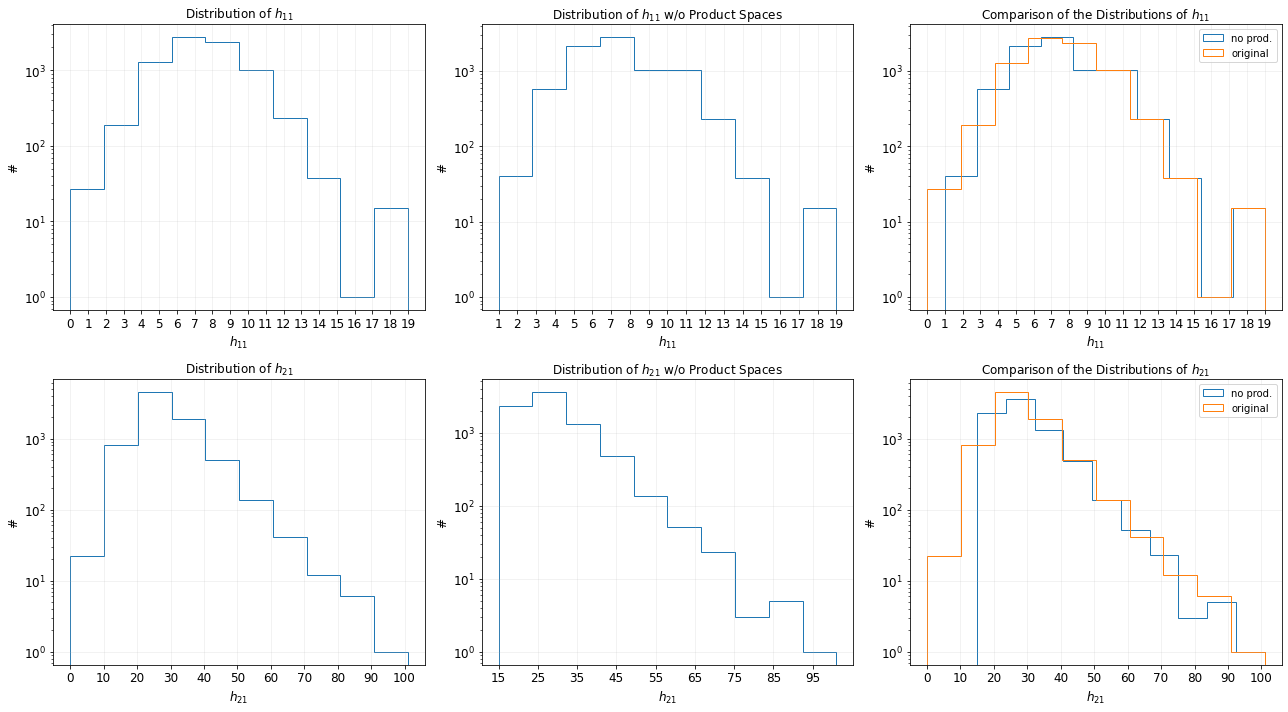

In [12]:
from mltools.libplot import Plot

plot = Plot(rows=2, columns=3)

plot.hist2D(df['h11'],        axis=(0,0), title='Distribution of $h_{11}$',                    xlabel='$h_{11}$', ylabel='#', ylog=True)
plot.hist2D(df_noprod['h11'], axis=(0,1), title='Distribution of $h_{11}$ w/o Product Spaces', xlabel='$h_{11}$', ylabel='#', ylog=True)
plot.hist2D(df_noprod['h11'], axis=(0,2), title='Comparison of the Distributions of $h_{11}$', xlabel='$h_{11}$', ylabel='#', ylog=True, legend='no prod.')
plot.hist2D(df['h11'],        axis=(0,2), title='Comparison of the Distributions of $h_{11}$', xlabel='$h_{11}$', ylabel='#', ylog=True, legend='original')

plot.hist2D(df['h21'],        axis=(1,0), title='Distribution of $h_{21}$',                    xlabel='$h_{21}$', ylabel='#', ylog=True, binstep=10)
plot.hist2D(df_noprod['h21'], axis=(1,1), title='Distribution of $h_{21}$ w/o Product Spaces', xlabel='$h_{21}$', ylabel='#', ylog=True, binstep=10)
plot.hist2D(df_noprod['h21'], axis=(1,2), title='Comparison of the Distributions of $h_{21}$', xlabel='$h_{21}$', ylabel='#', ylog=True, legend='no prod.', binstep=10)
plot.hist2D(df['h21'],        axis=(1,2), title='Comparison of the Distributions of $h_{21}$', xlabel='$h_{21}$', ylabel='#', ylog=True, legend='original', binstep=10)

plot.save_and_close(path.join(IMG_PATH, 'labels_distribution'))

### Remove the Outliers

In order to improve the training of the algorithms, we then remove the outliers of the distributions. We keep $h_{11} \in \left[ 1, 16 \right]$ and $h_{21} \in \left[ 1, 86 \right]$:

In [13]:
from mltools.libtransformer import RemoveOutliers

filter_dict = {'h11': [1, 16],
               'h21': [1, 86]
              }

df_noprod_noout = RemoveOutliers(filter_dict=filter_dict).fit_transform(df_noprod)
log.debug('Outliers removed.')

We then show the distribution of the newly extracted dataset in comparison with the previous versions:

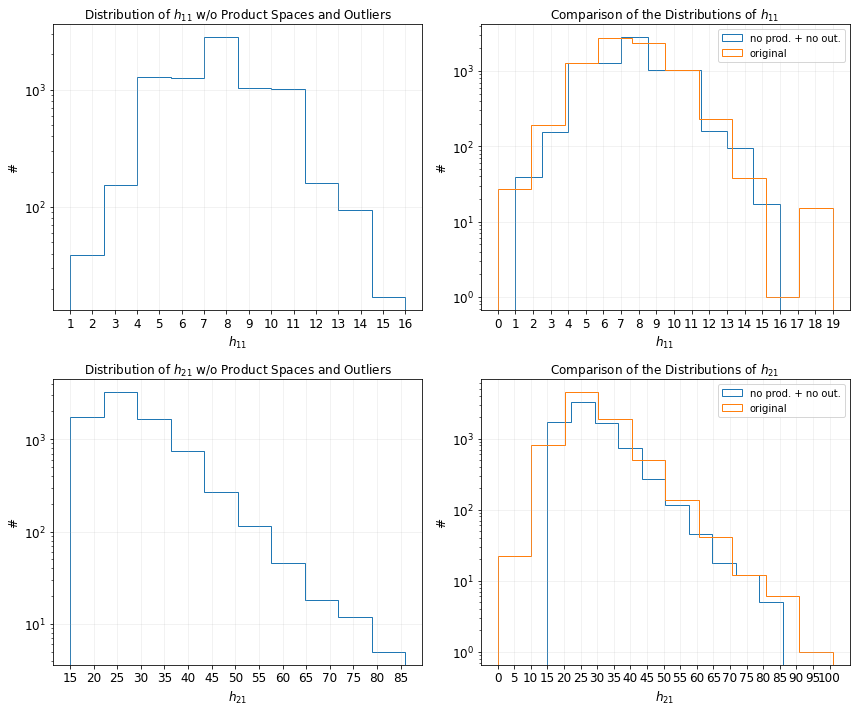

In [14]:
plot = Plot(rows=2, columns=2)

plot.hist2D(df_noprod_noout['h11'], axis=(0,0), title='Distribution of $h_{11}$ w/o Product Spaces and Outliers', xlabel='$h_{11}$', ylabel='#', ylog=True)
plot.hist2D(df_noprod_noout['h11'], axis=(0,1), title='Comparison of the Distributions of $h_{11}$',              xlabel='$h_{11}$', ylabel='#', ylog=True, legend='no prod. + no out.')
plot.hist2D(df['h11'],              axis=(0,1), title='Comparison of the Distributions of $h_{11}$',              xlabel='$h_{11}$', ylabel='#', ylog=True, legend='original')

plot.hist2D(df_noprod_noout['h21'], axis=(1,0), title='Distribution of $h_{21}$ w/o Product Spaces and Outliers', xlabel='$h_{21}$', ylabel='#', ylog=True, binstep=5)
plot.hist2D(df_noprod_noout['h21'], axis=(1,1), title='Comparison of the Distributions of $h_{21}$',              xlabel='$h_{21}$', ylabel='#', ylog=True, legend='no prod. + no out.', binstep=5)
plot.hist2D(df['h21'],              axis=(1,1), title='Comparison of the Distributions of $h_{21}$',              xlabel='$h_{21}$', ylabel='#', ylog=True, legend='original', binstep=5)

plot.save_and_close(path.join(IMG_PATH, 'labels_distribution_noout'))

### Data Visualisation

We can then move to the visualisation of the distribution of the labels as a function of several features (mainly scalars for visualisation reasons). In particular we first consider the scatter plot of $h_{11}$ and $h_{21}$ as functions of the **scalar** features and the **correlation matrix** of them, before moving to computing the **principal component analysis** (PCA) in 2D to plot the configuration matrix.

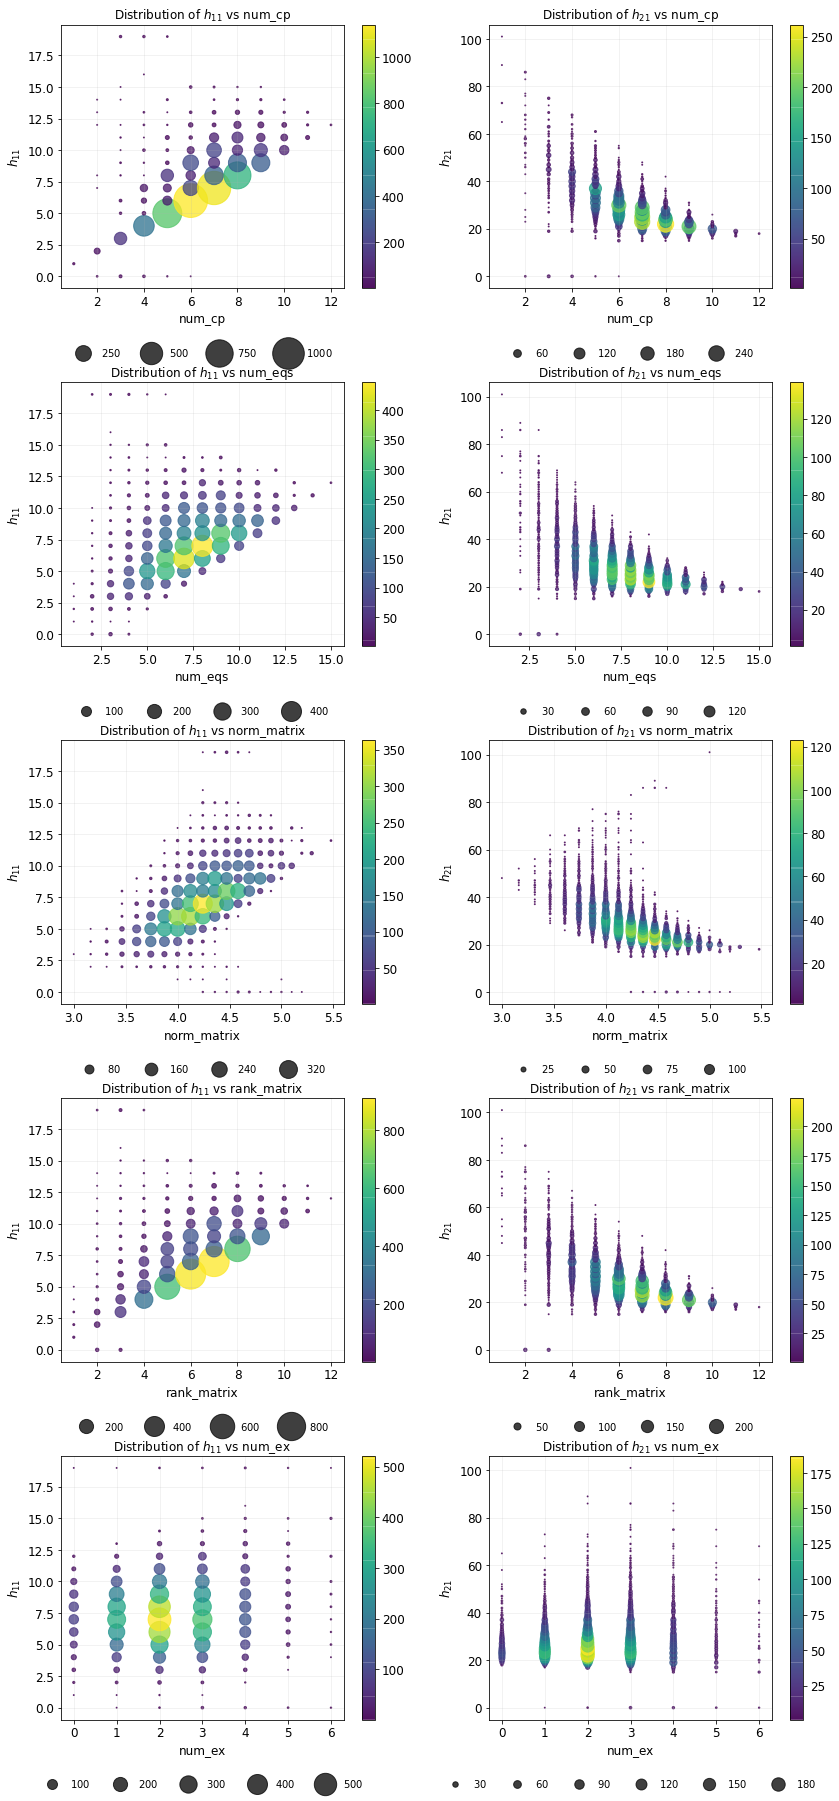

In [15]:
def get_counts(df, label, feature):
    '''
    Generator to produce the count of unique occurrencies of the data.
    
    Required arguments:
        df:      the Pandas dataframe
        label:   the label to consider
        feature: the feature to consider
        
    Yields:
        np.array([ unique feature, unique value, counts ])
    '''

    for n in np.sort(df[feature].unique()):
        uniques, counts = np.unique(df[label].loc[df[feature] == n].values,
                                    return_counts=True)
        
        for u, c in np.c_[uniques, counts]:
            yield np.array([ n, u, c ])

plot = Plot(rows=5, columns=2)

plot.scatter2D(data=np.array(list(get_counts(df, 'h11', 'num_cp'))).T,
               axis=(0,0),
               title='Distribution of $h_{11}$ vs num_cp',
               xlabel='num_cp',
               ylabel='$h_{11}$',
               size_labels=5,
               alpha=0.75
              )
plot.scatter2D(data=np.array(list(get_counts(df, 'h11', 'num_eqs'))).T,
               axis=(1,0),
               title='Distribution of $h_{11}$ vs num_eqs',
               xlabel='num_eqs',
               ylabel='$h_{11}$',
               size_labels=5,
               alpha=0.75
              )
plot.scatter2D(data=np.array(list(get_counts(df, 'h11', 'norm_matrix'))).T,
               axis=(2,0),
               title='Distribution of $h_{11}$ vs norm_matrix',
               xlabel='norm_matrix',
               ylabel='$h_{11}$',
               size_labels=5,
               alpha=0.75
              )
plot.scatter2D(data=np.array(list(get_counts(df, 'h11', 'rank_matrix'))).T,
               axis=(3,0),
               title='Distribution of $h_{11}$ vs rank_matrix',
               xlabel='rank_matrix',
               ylabel='$h_{11}$',
               size_labels=5,
               alpha=0.75
              )
plot.scatter2D(data=np.array(list(get_counts(df, 'h11', 'num_ex'))).T,
               axis=(4,0),
               title='Distribution of $h_{11}$ vs num_ex',
               xlabel='num_ex',
               ylabel='$h_{11}$',
               size_labels=5,
               alpha=0.75
              )

plot.scatter2D(data=np.array(list(get_counts(df, 'h21', 'num_cp'))).T,
               
               axis=(0,1),
               title='Distribution of $h_{21}$ vs num_cp',
               xlabel='num_cp',
               ylabel='$h_{21}$',
               size_labels=5,
               alpha=0.75
              )
plot.scatter2D(data=np.array(list(get_counts(df, 'h21', 'num_eqs'))).T,
               axis=(1,1),
               title='Distribution of $h_{21}$ vs num_eqs',
               xlabel='num_eqs',
               ylabel='$h_{21}$',
               size_labels=5,
               alpha=0.75
              )
plot.scatter2D(data=np.array(list(get_counts(df, 'h21', 'norm_matrix'))).T,
               axis=(2,1),
               title='Distribution of $h_{21}$ vs norm_matrix',
               xlabel='norm_matrix',
               ylabel='$h_{21}$',
               size_labels=5,
               alpha=0.75
              )
plot.scatter2D(data=np.array(list(get_counts(df, 'h21', 'rank_matrix'))).T,
               axis=(3,1),
               title='Distribution of $h_{21}$ vs rank_matrix',
               xlabel='rank_matrix',
               ylabel='$h_{21}$',
               size_labels=5,
               alpha=0.75
              )
plot.scatter2D(data=np.array(list(get_counts(df, 'h21', 'num_ex'))).T,
               axis=(4,1),
               title='Distribution of $h_{21}$ vs num_ex',
               xlabel='num_ex',
               ylabel='$h_{21}$',
               size_labels=5,
               alpha=0.75
              )

log.debug('Plotting distributions...')
plot.save_and_close(path.join(IMG_PATH, 'scalar_features_distribution'))

### Correlation Matrix

We then compute the correlation matrix of the scalar features:

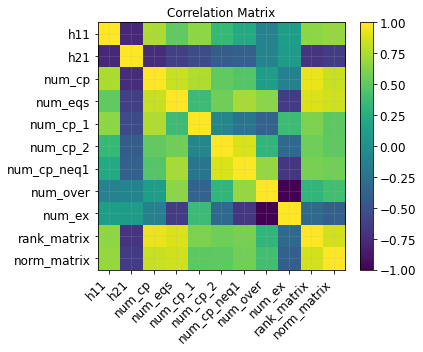

In [16]:
corr = df_noprod_noout[['h11', 'h21', 'num_cp', 'num_eqs', 'num_cp_1', 'num_cp_2', 'num_cp_neq1', 'num_over', 'num_ex', 'rank_matrix', 'norm_matrix']].corr()

log.debug('Plotting correlation matrix...')
Plot().matrix(data=corr, title='Correlation Matrix', xticks=corr.columns, yticks=corr.columns).save_and_close(path.join(IMG_PATH, 'correlation_matrix'))

### K Means Clustering

We then compute the **K Means** clustering labels for the matrix components to find structure in the data and be able to improve the training algorithms. This is an **unsupervised** preanalyisis: in this particular case we do not need to divide the dataset into training and validation sets, however it is best to shuffle the dataset.

In [17]:
df_shuffled = df_noprod_noout.sample(frac=1, random_state=RAND)

We then extract the matrix (flattened) to study the clustering algorithm.

In [18]:
from mltools.libtransformer import ExtractTensor

matrix = np.array(ExtractTensor(flatten=True).fit_transform(df_shuffled['matrix']))

Then we proceed with the clustering analysis:

In [19]:
from sklearn.cluster import KMeans

clusters      = range(2,16)
kmeans_labels = np.zeros((np.shape(matrix)[0], np.shape(clusters)[0]))

for n in clusters:
    print('Computing K Means clustering with {:d} clusters...'.format(n))
    log.info('Computing K Means clustering with {:d} clusters...'.format(n))
    kmeans_labels[:,n-clusters.start] = KMeans(n_clusters=n, random_state=RAND).fit_predict(matrix)
    
log.info('K Means clustering computed!')

Computing K Means clustering with 2 clusters...
Computing K Means clustering with 3 clusters...
Computing K Means clustering with 4 clusters...
Computing K Means clustering with 5 clusters...
Computing K Means clustering with 6 clusters...
Computing K Means clustering with 7 clusters...
Computing K Means clustering with 8 clusters...
Computing K Means clustering with 9 clusters...
Computing K Means clustering with 10 clusters...
Computing K Means clustering with 11 clusters...
Computing K Means clustering with 12 clusters...
Computing K Means clustering with 13 clusters...
Computing K Means clustering with 14 clusters...
Computing K Means clustering with 15 clusters...


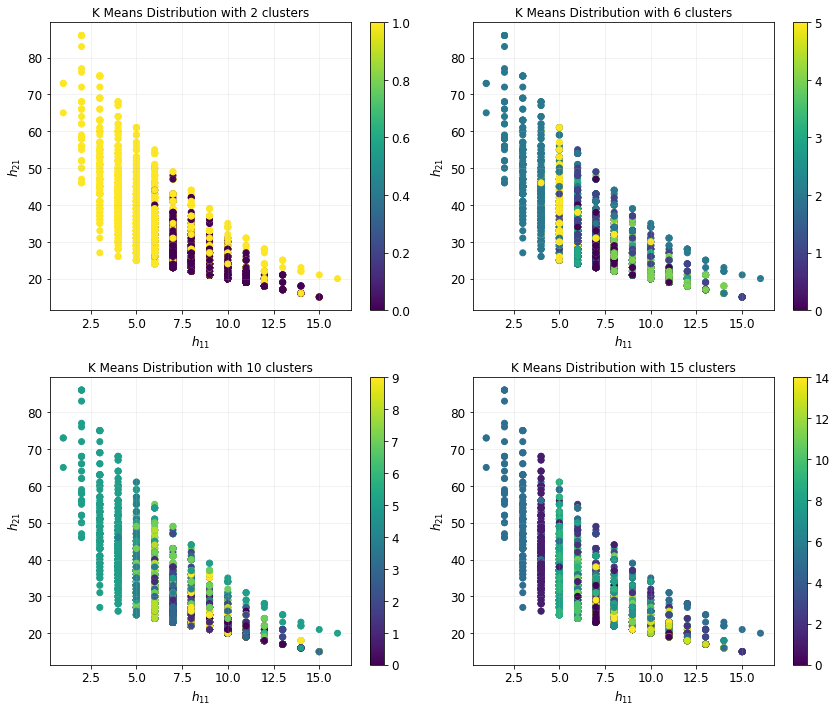

In [20]:
plot = Plot(rows=2, columns=2)

plot.scatter2D(data=[df_shuffled['h11'].values, df_shuffled['h21'].values, kmeans_labels[:,0]],
               axis=(0,0),
               title='K Means Distribution with 2 clusters',
               xlabel='$h_{11}$',
               ylabel='$h_{21}$',
               size=False,
               colour=True
              )
plot.scatter2D(data=[df_shuffled['h11'].values, df_shuffled['h21'].values, kmeans_labels[:,4]],
               axis=(0,1),
               title='K Means Distribution with 6 clusters',
               xlabel='$h_{11}$',
               ylabel='$h_{21}$',
               size=False,
               colour=True
              )
plot.scatter2D(data=[df_shuffled['h11'].values, df_shuffled['h21'].values, kmeans_labels[:,8]],
               axis=(1,0),
               title='K Means Distribution with 10 clusters',
               xlabel='$h_{11}$',
               ylabel='$h_{21}$',
               size=False,
               colour=True
              )
plot.scatter2D(data=[df_shuffled['h11'].values, df_shuffled['h21'].values, kmeans_labels[:,13]],
               axis=(1,1),
               title='K Means Distribution with 15 clusters',
               xlabel='$h_{11}$',
               ylabel='$h_{21}$',
               size=False,
               colour=True
              )

plot.save_and_close(path.join(IMG_PATH, 'cluster_distribution'))

### PCA

We then proceed with the **PCA** analysis with a twofold purpose: we first compute the 2 principal components of the **configuration matrix** to be able to plot the distribution of the matrix entries in a 2D plot, we then compute the PCA with **99% of the variance** retained.

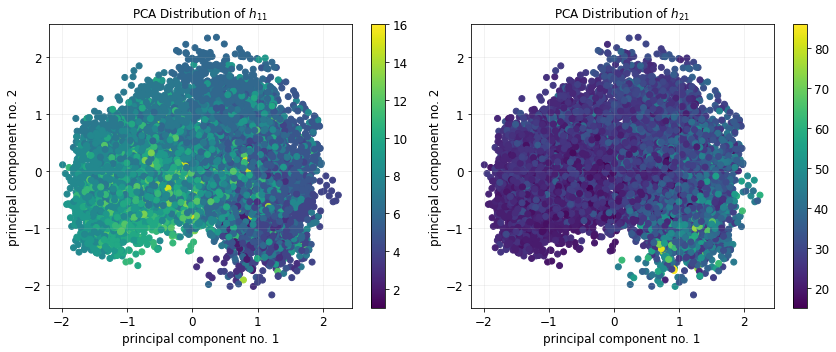

In [21]:
from sklearn.decomposition import PCA

log.info('Computing PCA with 2 components...')
pca2D_transformer = PCA(n_components=2, random_state=RAND)
pca2D = pca2D_transformer.fit_transform(matrix)
log.info('PCA variance retained for each component: {}'.format(pca2D_transformer.explained_variance_ratio_))

pca2D_plot_h11 = np.array([pca2D[:,0], pca2D[:,1], df_shuffled['h11'].values])
pca2D_plot_h21 = np.array([pca2D[:,0], pca2D[:,1], df_shuffled['h21'].values])

plot = Plot(rows=1, columns=2)

plot.scatter2D(data=pca2D_plot_h11,
               axis=0,
               title='PCA Distribution of $h_{11}$',
               xlabel='principal component no. 1',
               ylabel='principal component no. 2',
               size=False
              )
plot.scatter2D(data=pca2D_plot_h21,
               axis=1,
               title='PCA Distribution of $h_{21}$',
               xlabel='principal component no. 1',
               ylabel='principal component no. 2',
               size=False
              )

plot.save_and_close(path.join(IMG_PATH, 'pca_distribution'))

We then compute the PCA with **99% of variance** retained:

In [22]:
log.info('Computing PCA with 0.99 variance retained...')
pca99 = PCA(n_components=0.99, random_state=RAND).fit_transform(matrix)

print('No. of components of the decomposed matrix: {:d}'.format(np.shape(pca99)[1]))
log.info('PCA matrix components: {:d}'.format(np.shape(pca99)[1]))

No. of components of the decomposed matrix: 81


### Variable Ranking

We now select the features we are interested in ranking in order to select only those which can actually contribute to the prediction of $h_{11}$ and $h_{21}$. We divide them into **scalar**, **vector** and **tensor** (matrix) features and extract them from the dataset (we do not use them all: we avoid using the columns with _mean_, _max_, _min_ (_et similia_) in the name since they can be easily extracted from other features.

In [23]:
scalars = ['num_cp', 'num_eqs', 'num_cp_1', 'num_cp_2', 'num_cp_neq1', 'num_over', 'num_ex', 'rank_matrix', 'norm_matrix']
vectors = ['dim_cp', 'num_dim_cp', 'deg_eqs', 'num_deg_eqs', 'dim_h0_amb']

We now build a matrix to hold each entry of the dataset in rows and each feature in columns. We start from the scalars and then we add the vectors after the extraction from the sparse format in which they are currently stored.

In [24]:
ranking_features = np.zeros((np.shape(df_shuffled)[0], np.shape(scalars)[0]), dtype=np.float)
ranking_lengths  = np.ones(np.shape(scalars)[0], dtype=np.int)

for n in range(np.shape(scalars)[0]):
    ranking_features[:,n] = ExtractTensor(flatten=True).fit_transform(df_shuffled[scalars[n]])

We can now extract the vector features from the dataset:

In [25]:
for feature in vectors:
    vector           = ExtractTensor(flatten=True).fit_transform(df_shuffled[feature])
    ranking_features = np.c_[ranking_features, vector]
    ranking_lengths  = np.append(ranking_lengths, np.shape(vector)[1])

We now proceed to the variable ranking in two ways:

1. using `ranking_features`, `kmeans_labels` and `matrix`
2. using `ranking_features`, `kmeans_labels` and `pca99`

to avoid redundancies in the computation. We use a **Random Forest** algorithm in the _Scikit_ implementation. At this stage we are not interested in predictions, thus it is not necessary to fine tune the algorithm. Being the random forest and ensemble estimator, we use a reasonable amount of base estimators and do not worry too much about overfitting the set.

In [26]:
from sklearn.ensemble import RandomForestRegressor
from mltools.libscore import Score

log.info('Fitting random forest on h11 for variable ranking...')
rnd_for = RandomForestRegressor(n_estimators=100,
                                random_state=RAND,
                                n_jobs=-1
                               )

We now start from the first variable ranking (with the configuration matrix):

In [27]:
features = np.c_[ranking_features,
                 kmeans_labels,
                 matrix] #------------------------------------------------------------------------- build the feature vector

ranking_labels = [] #------------------------------------------------------------------------------ initialise label list
for n in range(np.shape(scalars + vectors)[0]):
    ranking_labels.append((scalars + vectors)[n])
    for _ in range(ranking_lengths[n]-1):
        ranking_labels.append('') #---------------------------------------------------------------- add features labels
    
for n in range(np.shape(kmeans_labels)[1]):
    ranking_labels.append('{:d} clusters'.format(n + clusters.start)) #---------------------------- add clustering labels
    
ranking_labels.append('matrix')
for _ in range(np.shape(matrix)[1]-1):
    ranking_labels.append('') #-------------------------------------------------------------------- add matrix labels

rnd_for.fit(X=features,
            y=df_shuffled['h11'].values,
           ) #------------------------------------------------------------------------------------- fit the random forest on h11
log.debug('Acc. of the RF on h11: {:.3f}%'.format(Score(y_true=df_shuffled['h11'].values,
                                                        y_pred=rnd_for.predict(features),
                                                        rounding=np.floor).accuracy() * 100)) #---- compute accuracy (for fun)

importances_mat_h11 = list(zip(ranking_labels, rnd_for.feature_importances_)) #-------------------- get the importances for h11

rnd_for.fit(X=features,
            y=df_shuffled['h21'].values,
           ) #------------------------------------------------------------------------------------- fit the random forest on h21
log.debug('Acc. of the RF on h21: {:.3f}%'.format(Score(y_true=df_shuffled['h21'].values,
                                                        y_pred=rnd_for.predict(features),
                                                        rounding=np.floor).accuracy() * 100)) #---- compute accuracy (for fun)

importances_mat_h21 = list(zip(ranking_labels, rnd_for.feature_importances_)) #-------------------- get the importances for h21

We then compute the same with the PCA components:

In [28]:
features = np.c_[ranking_features,
                 kmeans_labels,
                 pca99] #-------------------------------------------------------------------------- build the feature vector

ranking_labels = [] #------------------------------------------------------------------------------ initialise label list
for n in range(np.shape(scalars + vectors)[0]):
    ranking_labels.append((scalars + vectors)[n])
    for _ in range(ranking_lengths[n]-1):
        ranking_labels.append('') #---------------------------------------------------------------- add features labels
    
for n in range(np.shape(kmeans_labels)[1]):
    ranking_labels.append('{:d} clusters'.format(n + clusters.start)) #---------------------------- add clustering labels
    
ranking_labels.append('pca')
for _ in range(np.shape(pca99)[1]-1):
    ranking_labels.append('') #-------------------------------------------------------------------- add pca labels

rnd_for.fit(X=features,
            y=df_shuffled['h11'].values,
           ) #------------------------------------------------------------------------------------- fit the random forest on h11
log.debug('Acc. of the RF on h11: {:.3f}%'.format(Score(y_true=df_shuffled['h11'].values,
                                                        y_pred=rnd_for.predict(features),
                                                        rounding=np.floor).accuracy() * 100)) #---- compute accuracy (for fun)

importances_pca_h11 = list(zip(ranking_labels, rnd_for.feature_importances_)) #-------------------- get the importances for h11

rnd_for.fit(X=features,
            y=df_shuffled['h21'].values,
           ) #------------------------------------------------------------------------------------- fit the random forest on h21
log.debug('Acc. of the RF on h21: {:.3f}%'.format(Score(y_true=df_shuffled['h21'].values,
                                                        y_pred=rnd_for.predict(features),
                                                        rounding=np.floor).accuracy() * 100)) #---- compute accuracy (for fun)

importances_pca_h21 = list(zip(ranking_labels, rnd_for.feature_importances_)) #-------------------- get the importances for h21

#### Separate Feature Visualisation

We then proceed with the visualisation of the feature importances:

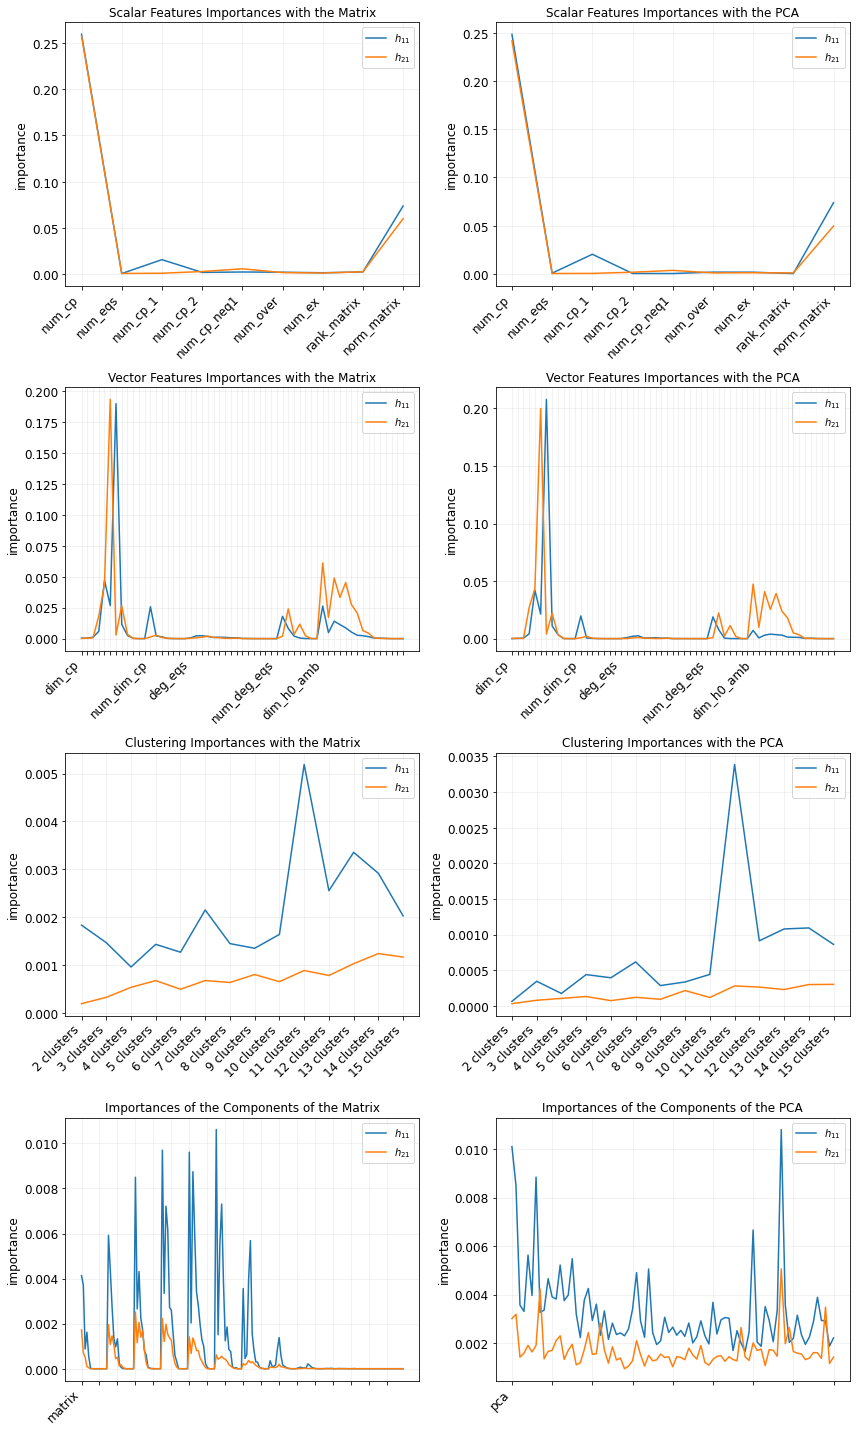

In [29]:
# define the data for the plots
scalars_mat_lab  = [i[0] for i in importances_mat_h11[0:np.shape(scalars)[0]]]
scalars_mat_h11  = [i[1] for i in importances_mat_h11[0:np.shape(scalars)[0]]]
scalars_mat_h21  = [i[1] for i in importances_mat_h21[0:np.shape(scalars)[0]]] #------------------------- scalar features with the matrix

scalars_pca_lab  = [i[0] for i in importances_pca_h11[0:np.shape(scalars)[0]]]
scalars_pca_h11  = [i[1] for i in importances_pca_h11[0:np.shape(scalars)[0]]]
scalars_pca_h21  = [i[1] for i in importances_pca_h21[0:np.shape(scalars)[0]]] #------------------------- scalar features with the pca

vector_index     = np.shape(scalars)[0] + np.sum(ranking_lengths[np.shape(scalars)[0]:])
vectors_mat_lab  = [i[0] for i in importances_mat_h11[np.shape(scalars)[0]:vector_index]]
vectors_mat_h11  = [i[1] for i in importances_mat_h11[np.shape(scalars)[0]:vector_index]]
vectors_mat_h21  = [i[1] for i in importances_mat_h21[np.shape(scalars)[0]:vector_index]] #-------------- vector features with the matrix

vectors_pca_lab  = [i[0] for i in importances_pca_h11[np.shape(scalars)[0]:vector_index]]
vectors_pca_h11  = [i[1] for i in importances_pca_h11[np.shape(scalars)[0]:vector_index]]
vectors_pca_h21  = [i[1] for i in importances_pca_h21[np.shape(scalars)[0]:vector_index]] #-------------- vector features with the pca

cluster_index    = vector_index + np.shape(kmeans_labels)[1]
clusters_mat_lab = [i[0] for i in importances_mat_h11[vector_index:cluster_index]]
clusters_mat_h11 = [i[1] for i in importances_mat_h11[vector_index:cluster_index]]
clusters_mat_h21 = [i[1] for i in importances_mat_h21[vector_index:cluster_index]] #--------------------- cluster ranking with the matrix

clusters_pca_lab = [i[0] for i in importances_pca_h11[vector_index:cluster_index]]
clusters_pca_h11 = [i[1] for i in importances_pca_h11[vector_index:cluster_index]]
clusters_pca_h21 = [i[1] for i in importances_pca_h21[vector_index:cluster_index]] #--------------------- cluster ranking with the pca

mat_lab          = [i[0] for i in importances_mat_h11[cluster_index:]]
mat_h11          = [i[1] for i in importances_mat_h11[cluster_index:]]
mat_h21          = [i[1] for i in importances_mat_h21[cluster_index:]] #--------------------------------- matrix importances

pca_lab          = [i[0] for i in importances_pca_h11[cluster_index:]]
pca_h11          = [i[1] for i in importances_pca_h11[cluster_index:]]
pca_h21          = [i[1] for i in importances_pca_h21[cluster_index:]] #--------------------------------- pca importances


# plot the results
plot = Plot(rows=4, columns=2)

plot.series2D(data=scalars_mat_h11,  axis=(0,0), title='Scalar Features Importances with the Matrix', ylabel='importance', legend='$h_{11}$', labels=scalars_mat_lab)
plot.series2D(data=scalars_mat_h21,  axis=(0,0), title='Scalar Features Importances with the Matrix', ylabel='importance', legend='$h_{21}$', labels=scalars_mat_lab)
plot.series2D(data=scalars_pca_h11,  axis=(0,1), title='Scalar Features Importances with the PCA',    ylabel='importance', legend='$h_{11}$', labels=scalars_pca_lab)
plot.series2D(data=scalars_pca_h21,  axis=(0,1), title='Scalar Features Importances with the PCA',    ylabel='importance', legend='$h_{21}$', labels=scalars_pca_lab)

plot.series2D(data=vectors_mat_h11,  axis=(1,0), title='Vector Features Importances with the Matrix', ylabel='importance', legend='$h_{11}$', labels=vectors_mat_lab)
plot.series2D(data=vectors_mat_h21,  axis=(1,0), title='Vector Features Importances with the Matrix', ylabel='importance', legend='$h_{21}$', labels=vectors_mat_lab)
plot.series2D(data=vectors_pca_h11,  axis=(1,1), title='Vector Features Importances with the PCA',    ylabel='importance', legend='$h_{11}$', labels=vectors_pca_lab)
plot.series2D(data=vectors_pca_h21,  axis=(1,1), title='Vector Features Importances with the PCA',    ylabel='importance', legend='$h_{21}$', labels=vectors_pca_lab)

plot.series2D(data=clusters_mat_h11, axis=(2,0), title='Clustering Importances with the Matrix',      ylabel='importance', legend='$h_{11}$', labels=clusters_mat_lab)
plot.series2D(data=clusters_mat_h21, axis=(2,0), title='Clustering Importances with the Matrix',      ylabel='importance', legend='$h_{21}$', labels=clusters_mat_lab)
plot.series2D(data=clusters_pca_h11, axis=(2,1), title='Clustering Importances with the PCA',         ylabel='importance', legend='$h_{11}$', labels=clusters_pca_lab)
plot.series2D(data=clusters_pca_h21, axis=(2,1), title='Clustering Importances with the PCA',         ylabel='importance', legend='$h_{21}$', labels=clusters_pca_lab)

plot.series2D(data=mat_h11,          axis=(3,0), title='Importances of the Components of the Matrix', ylabel='importance', legend='$h_{11}$', labels=mat_lab, binstep=10)
plot.series2D(data=mat_h21,          axis=(3,0), title='Importances of the Components of the Matrix', ylabel='importance', legend='$h_{21}$', labels=mat_lab, binstep=10)
plot.series2D(data=pca_h11,          axis=(3,1), title='Importances of the Components of the PCA',    ylabel='importance', legend='$h_{11}$', labels=pca_lab, binstep=10)
plot.series2D(data=pca_h21,          axis=(3,1), title='Importances of the Components of the PCA',    ylabel='importance', legend='$h_{21}$', labels=pca_lab, binstep=10)

plot.save_and_close(path.join(IMG_PATH, 'feature_importances'))

To better visualise the results we also compute the sum of the importances to compare the various contributions:

In [30]:
# sum of the scalar contributions
scalars_sum_mat_h11  = np.sum([i[1] for i in importances_mat_h11[0:np.shape(scalars)[0]]])
scalars_sum_mat_h21  = np.sum([i[1] for i in importances_mat_h21[0:np.shape(scalars)[0]]])
scalars_sum_pca_h11  = np.sum([i[1] for i in importances_pca_h11[0:np.shape(scalars)[0]]])
scalars_sum_pca_h21  = np.sum([i[1] for i in importances_pca_h21[0:np.shape(scalars)[0]]])

# sum of the vector contributions (cumulative)
vectors_sum_mat_h11  = np.sum([i[1] for i in importances_mat_h11[np.shape(scalars)[0]:vector_index]])
vectors_sum_mat_h21  = np.sum([i[1] for i in importances_mat_h21[np.shape(scalars)[0]:vector_index]])
vectors_sum_pca_h11  = np.sum([i[1] for i in importances_pca_h11[np.shape(scalars)[0]:vector_index]])
vectors_sum_pca_h21  = np.sum([i[1] for i in importances_pca_h21[np.shape(scalars)[0]:vector_index]])

# sum of vectors contributions (separate)
vectors_sum_separate_mat_h11 = []
vectors_sum_separate_mat_h21 = []
vectors_sum_separate_pca_h11 = []
vectors_sum_separate_pca_h21 = []

i = 0
for l in ranking_lengths[np.shape(scalars)[0]:]:
    vectors_sum_separate_mat_h11.append(np.sum(vectors_mat_h11[i:i+l]))
    vectors_sum_separate_mat_h21.append(np.sum(vectors_mat_h21[i:i+l]))
    vectors_sum_separate_pca_h11.append(np.sum(vectors_pca_h11[i:i+l]))
    vectors_sum_separate_pca_h21.append(np.sum(vectors_pca_h21[i:i+l]))
    i = i + l

# sum of the cluster contributions
clusters_sum_mat_h11 = np.sum([i[1] for i in importances_mat_h11[vector_index:cluster_index]])
clusters_sum_mat_h21 = np.sum([i[1] for i in importances_mat_h21[vector_index:cluster_index]])
clusters_sum_pca_h11 = np.sum([i[1] for i in importances_pca_h11[vector_index:cluster_index]])
clusters_sum_pca_h21 = np.sum([i[1] for i in importances_pca_h21[vector_index:cluster_index]])

# sum of the matrix and pca contribution
mat_sum_h11          = np.sum([i[1] for i in importances_mat_h11[cluster_index:]])
mat_sum_h21          = np.sum([i[1] for i in importances_mat_h21[cluster_index:]])
pca_sum_h11          = np.sum([i[1] for i in importances_pca_h11[cluster_index:]])
pca_sum_h21          = np.sum([i[1] for i in importances_pca_h21[cluster_index:]])

#### Cumulative Feature Visualisation

We can then plot separately the cumulative contributions of the vector and tensor features:

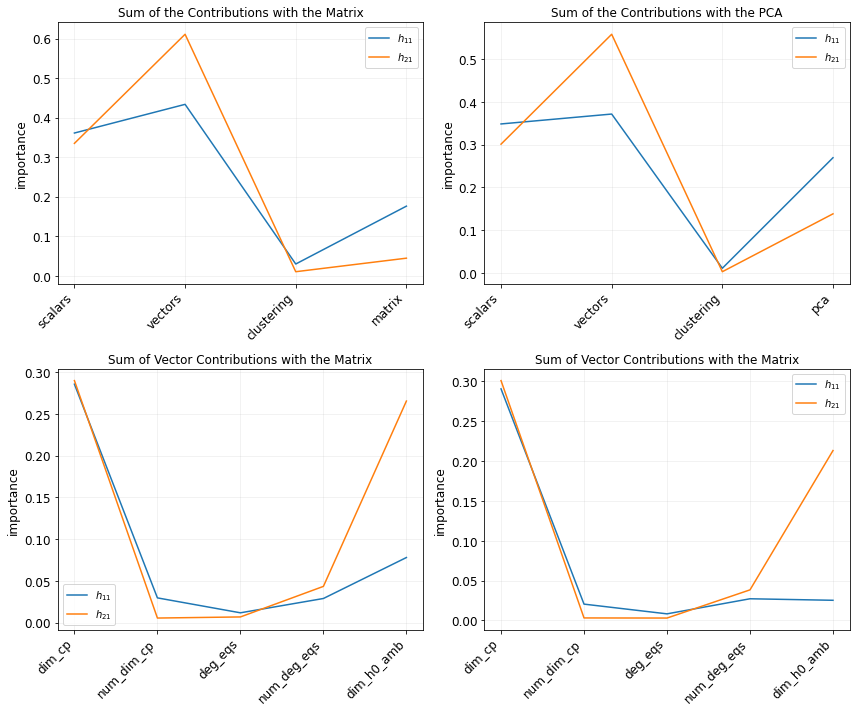

In [31]:
plot = Plot(rows=2, columns=2)

plot.series2D(data=[scalars_sum_mat_h11, vectors_sum_mat_h11, clusters_sum_mat_h11, mat_sum_h11],
              axis=(0,0),
              title='Sum of the Contributions with the Matrix',
              ylabel='importance',
              legend='$h_{11}$',
              labels=['scalars', 'vectors', 'clustering', 'matrix']
             )
plot.series2D(data=[scalars_sum_mat_h21, vectors_sum_mat_h21, clusters_sum_mat_h21, mat_sum_h21],
              axis=(0,0),
              title='Sum of the Contributions with the Matrix',
              ylabel='importance',
              legend='$h_{21}$',
              labels=['scalars', 'vectors', 'clustering', 'matrix']
             )

plot.series2D(data=[scalars_sum_pca_h11, vectors_sum_pca_h11, clusters_sum_pca_h11, pca_sum_h11],
              axis=(0,1),
              title='Sum of the Contributions with the PCA',
              ylabel='importance',
              legend='$h_{11}$',
              labels=['scalars', 'vectors', 'clustering', 'pca']
             )
plot.series2D(data=[scalars_sum_pca_h21, vectors_sum_pca_h21, clusters_sum_pca_h21, pca_sum_h21],
              axis=(0,1),
              title='Sum of the Contributions with the PCA',
              ylabel='importance',
              legend='$h_{21}$',
              labels=['scalars', 'vectors', 'clustering', 'pca']
             )

plot.series2D(data=vectors_sum_separate_mat_h11,
              axis=(1,0),
              title='Sum of Vector Contributions with the Matrix',
              ylabel='importance',
              legend='$h_{11}$',
              labels=vectors
             )
plot.series2D(data=vectors_sum_separate_mat_h21,
              axis=(1,0),
              title='Sum of Vector Contributions with the Matrix',
              ylabel='importance',
              legend='$h_{21}$',
              labels=vectors
             )

plot.series2D(data=vectors_sum_separate_pca_h11,
              axis=(1,1),
              title='Sum of Vector Contributions with the Matrix',
              ylabel='importance',
              legend='$h_{11}$',
              labels=vectors
             )
plot.series2D(data=vectors_sum_separate_pca_h21,
              axis=(1,1),
              title='Sum of Vector Contributions with the Matrix',
              ylabel='importance',
              legend='$h_{21}$',
              labels=vectors
             )

plot.save_and_close(path.join(IMG_PATH, 'feature_importances_sum'))

## Discussion and Feature Selection

From the results of the preanalysis we see that there are indeed features which play a stronger role in predicting the labels. In particular we find that **more correlated** features (see the [correlation matrix](#Correlation-Matrix)) are usually **more relevant** in a decision tree, at least for scalar features. For instance `num_cp` (and `norm_matrix`, even though more marginal and mostly related to $h_{11}$ more than $h_{21}$) is a relevant **scalar** feature (see the [feature importances](#Separate-Feature-Visualisation)) for the predictions of both $h_{11}$ and $h_{21}$ and we should certainly select it in the analysis.

The vector features are instead a bit more complicated and dependending on the use of the **configuration matrix** or its **pca**, we get slightly different results: in both cases `dim_cp` is a good marker for the predictions of both Hodge numbers (and we will certainly select it), while `dim_h0_amb` is extremely relevant only for $h_{21}$ (as shown in the [cumulative plots](#Cumulative-Feature_Visualisation)). For $h_{11}$ it gains a bit more relevance when the **configuration matrix** is used.

The [clustering](#K-Means-Clustering) analysis shows that there are no visible or recognasible clusters in the data. In fact even the variable ranking seems to hint to the fact that more clusters usually lead to more relevant features (the final result with 15 clusters for $h_{11}$ is almost equal to a classification task, since the number of clusters almost equals the number of "classes" in the label $h_{11}$, that is the number of clusters spans the entire range of $h_{11}$). Additionally, even choosing the more relevant number of clusters, the _K Means_ analysis does not play a relevant role and should not be considered as a feature for the analysis.

Finally the [PCA](#PCA) certainly contains more relevant information than the matrix itself and it will end up being the final choice, even though we will perform a baseline analysis containing only the matrix for comparison.

In order to avoid introducing personal bias or arbitrariness, we then choose only the features with a variable ranking $\ge 10%$ (for the vector and tensor features this is computed cumulatively, not per entry). We will therefore select the following features, which will then be addressed collectively as the _feature engineered_ set:

- `num_cp`, `dim_cp`, `pca99` for the prediction of $h_{11}$,
- `num_cp`, `dim_cp`, `dim_h0_amb`, `pca99` for the prediction of $h_{21}$.

We will then perform the following analysis:

- a baseline using `matrix` for both $h_{11}$ and $h_{21}$ (both for performance analysis and comparison with [_Bull et al._](https://arxiv.org/abs/1806.03121)),
- a check using only the engineered features such as `num_cp`, `norm_matrix`, etc. withouth `matrix` or `pca99`,
- the complete result using the feature engineered set.

We now extract the needed features and save them to file.

In [32]:
import joblib

# dump matrix
joblib.dump(value=df_shuffled['matrix'],
            filename=path.join(ROOT_DIR, DB_NAME + '_matrix.joblib.xz'),
            compress=('xz',9)
           )

# dump PCA
joblib.dump(value=pca99,
            filename=path.join(ROOT_DIR, DB_NAME + '_pca.joblib.xz'),
            compress=('xz',9)
           )

# dump feature selection (including the labels!)
joblib.dump(value=df_shuffled[['h11', 'h21', 'num_cp', 'dim_cp', 'dim_h0_amb']],
            filename=path.join(ROOT_DIR, DB_NAME + '_selection.joblib.xz'),
            compress=('xz',9)
           )

print('Features have been saved to file!')
log.debug('Matrix saved to {}.'.format(path.join(ROOT_DIR, DB_NAME + '_matrix.joblib.xz')))
log.debug('PCA saved to {}.'.format(path.join(ROOT_DIR, DB_NAME + '_pca.joblib.xz')))
log.debug('Selection of features saved to {}.'.format(path.join(ROOT_DIR, DB_NAME + '_selection.joblib.xz')))

Features have been saved to file!
